### 相关性分析
为什么我们这里使用？

相关性分析是用来评估公园的一些特征与公园~~周围服务人口~~面积和服务类型的关系。

(之前那一版的效果不好,这里有所更改)

所以是什么特征呢？

公园的可达性 | 公园周围环境的特征 | 公园周围人口的特征

**公园的可达性**

公园到附近的自行车网络的最短距离

公园到附近的metro车站的最短距离

公园步行范围内的metro车站数目

**公园周围环境的特征**

公园10分钟步行范围内可抵达的公立学校数目 （居民）

公园10分钟步行范围内可抵达的住宅数目

公园10分钟步行范围内可抵达的廉租房数目

公园10分钟步行范围内可抵达的其他的landmarks数目 （visitor）

公园10分钟步行范围内可抵达的公司数目（通过就业人口来决定） (employer)

**公园周围人口的特征**

公园步行10分钟范围老年人比例

公园步行10分钟范围儿童比例

公园最近5个邻近公园的平均人口密度

#### 整理数据

In [1]:
from shapely.geometry import box
import matplotlib.pyplot as plt
from contextily import add_basemap
import contextily as cx
from shapely.geometry import Point, Polygon
from shapely.ops import transform
from pyproj import Transformer
import geopandas as gpd
import numpy as np
import time
import requests
import pandas as pd

In [2]:
# 选择适合的投影坐标系统
projected_crs = '3857'  # Web Mercator 投影

In [4]:
# 整理相关性分析需要的数据

In [3]:
parks_with_amenities = pd.read_csv('park_related_properties.csv')
parks_with_demographic = pd.read_csv('parks_isochrones_with_demographic.csv')

parks_with_info = pd.merge(parks_with_amenities,parks_with_demographic,on = 'OBJECTID',how = 'outer')
parks_with_info.head()

,Unnamed: 0_x,OBJECTID,isochrones_x,centroid_x,Schools_count,Landmarks_count,Metros_count,Housings_count,Affordable_Housings_count,job_count,...,distance_to_nearest_bike_network,Unnamed: 0_y,isochrones_y,centroid_y,POP_DENSITY,EMPLOYED_PERCENTAGE,UNDER5_PERCENTAGE,65_PERCENTAGE,PEOPLE_OF_COLOR_PERCENTAGE,POVERTY_PERCENTAGE
0,0,658736,"POLYGON ((-13620700 6057390, -13620800 6057360...",POINT (-13614900 6048020),0,0,66,30,20,0,...,13.528561,2087,"POLYGON ((-13623834.433581 6052957.542862, -13...",POINT (-13614889.524478 6048020.708636),3810.171223,71.304379,3.498425,8.608949,36.059198,7.691498
1,1,658737,"POLYGON ((-13622400 6036770, -13622600 6036870...",POINT (-13611600 6052440),0,0,30,0,1,0,...,29.330247,2189,"POLYGON ((-13611845.99234 6028495.611318, -136...",POINT (-13611635.960618 6052435.229062),1155.846725,45.255925,6.406198,14.604505,72.800813,13.735435
2,2,658738,"POLYGON ((-13625600 6048770, -13626000 6048240...",POINT (-13613800 6060200),1,3,50,0,5,0,...,14.313898,2162,"POLYGON ((-13614363.259985 6048076.364085, -13...",POINT (-13613848.548785 6060204.356927),609.178640,45.584900,3.566884,20.829435,24.834771,2.460945
3,3,658739,"POLYGON ((-13624100 6057330, -13624300 6057170...",POINT (-13615500 6042810),1,0,48,6,2,0,...,39.834804,1793,"POLYGON ((-13619921.998758 6049763.383101, -13...",POINT (-13615537.64542 6042812.635743),2172.068963,76.271880,2.686745,6.217388,27.411512,7.667199
4,4,658740,"POLYGON ((-13613600 6039830, -13614000 6039370...",POINT (-13621200 6051950),0,0,116,47,10,0,...,17.301565,2605,"POLYGON ((-13614024.180816 6039228.756629, -13...",POINT (-13621169.499321 6051948.838358),1430.020946,54.140358,3.122537,19.770997,58.161291,6.913684


In [7]:
# 删掉一些列,让表格更整齐
parks_with_info = parks_with_info.drop(columns = ['Unnamed: 0_x','isochrones_x','centroid_x','Unnamed: 0_y','isochrones_y','centroid_y'])

In [8]:
parks_with_info.head()

,OBJECTID,Schools_count,Landmarks_count,Metros_count,Housings_count,Affordable_Housings_count,job_count,nearest_residential_distance,nearest_MHA_distance,nearest_metro_distance,nearest_school_distance,nearest_landmark_distance,nearest_park_distance,distance_to_nearest_bike_network,POP_DENSITY,EMPLOYED_PERCENTAGE,UNDER5_PERCENTAGE,65_PERCENTAGE,PEOPLE_OF_COLOR_PERCENTAGE,POVERTY_PERCENTAGE
0,658736,0,0,66,30,20,0,427.178937,194.700850,26.327768,745.930962,1933.309978,84.788660,13.528561,3810.171223,71.304379,3.498425,8.608949,36.059198,7.691498
1,658737,0,0,30,0,1,0,672.926053,498.248427,422.412833,1420.018708,2124.291416,445.692996,29.330247,1155.846725,45.255925,6.406198,14.604505,72.800813,13.735435
2,658738,1,3,50,0,5,0,279.787641,0.000000,38.681859,1442.800117,344.594832,51.310402,14.313898,609.178640,45.584900,3.566884,20.829435,24.834771,2.460945
3,658739,1,0,48,6,2,0,76.215711,0.000000,162.498454,135.981734,813.829535,38.281059,39.834804,2172.068963,76.271880,2.686745,6.217388,27.411512,7.667199
4,658740,0,0,116,47,10,0,53.035010,0.000000,192.613199,309.629807,1527.372924,277.578996,17.301565,1430.020946,54.140358,3.122537,19.770997,58.161291,6.913684


In [10]:
# parks_detail
parks_detail = gpd.read_file('park_details_isochrones_10_walking_gdf.geojson')
parks_detail = parks_detail.to_crs(epsg=projected_crs)  
parks_detail.columns

Index(['OBJECTID', 'NAME', 'PMA_NAME', 'ADDRESS', 'PIN', 'SUBPARCEL',
       'TOTAL_AREA', 'OWNER', 'LEASE', 'MAINT', 'TYPE', 'ACQ_DATE', 'NAMEFLAG',
       'REVIEW_DATE', 'AMWOID', 'SDQL', 'SE_ANNO_CAD_DATA', 'GIS_CRT_DT',
       'GIS_EDT_DT', 'GlobalID', 'centroid', 'isochrones', 'geometry'],
      dtype='object')

In [16]:
parks_detail.head()

,OBJECTID,NAME,PMA_NAME,ADDRESS,PIN,SUBPARCEL,TOTAL_AREA,OWNER,LEASE,MAINT,...,REVIEW_DATE,AMWOID,SDQL,SE_ANNO_CAD_DATA,GIS_CRT_DT,GIS_EDT_DT,GlobalID,centroid,isochrones,geometry
0,660345,SEOLA PARK,Seola Park,,7110000066,22024.0,466,DPR,N,DPR,...,"Wed, 06 Jan 2010 00:00:00 GMT",PROPERTY-SEOPK,QL-D1,,"Mon, 12 Aug 2024 10:38:53 GMT","Mon, 12 Aug 2024 10:38:53 GMT",256c97cb-6578-415f-b9fe-853a0b214545,POINT (-13622744.893154 6023634.083662),"POLYGON ((-13623319.469617 6031677.955953, -13...","POLYGON ((-13622737.379 6023640.776, -13622737..."
1,659362,SEOLA PARK,Seola Park,,1123039030,9627.0,466,DPR,N,DPR,...,"Wed, 06 May 1998 00:00:00 GMT",PROPERTY-SEOPK,QL-D1,,"Mon, 12 Aug 2024 10:38:53 GMT","Mon, 12 Aug 2024 10:38:53 GMT",4ebb3649-92bc-47a2-ac6a-1b390060f5d7,POINT (-13622815.0938 6023678.225553),"POLYGON ((-13612891.838956 6039350.07867, -136...","POLYGON ((-13622809.153 6023663.187, -13622830..."
2,659360,SEOLA PARK,Seola Park,,1223039013,9627.0,466,DPR,N,DPR,...,"Wed, 06 May 1998 00:00:00 GMT",PROPERTY-SEOPK,QL-D1,,"Mon, 12 Aug 2024 10:38:53 GMT","Mon, 12 Aug 2024 10:38:53 GMT",b7f6f0f5-97ac-4e35-ab5a-51e612165b99,POINT (-13622787.819986 6023732.238333),"POLYGON ((-13621166.439346 6062868.220189, -13...","POLYGON ((-13622749.842 6023792.899, -13622739..."
3,660174,SEOLA PARK,Seola Park,None,None,9627.0,466,DPR,N,DPR,...,"Wed, 07 Apr 2004 00:00:00 GMT",PROPERTY-SEOPK,QL-D1,,"Mon, 12 Aug 2024 10:38:53 GMT","Mon, 12 Aug 2024 10:38:53 GMT",e1df0af1-cdbb-463c-b3f0-a0da44649b78,POINT (-13622852.340365 6023754.704958),"POLYGON ((-13611805.026767 6028358.780275, -13...","POLYGON ((-13622845.404 6023793.752, -13622846..."
4,659359,SEOLA PARK,Seola Park,,1123039028,9628.0,466,DPR,N,DPR,...,"Wed, 06 May 1998 00:00:00 GMT",PROPERTY-SEOPK,QL-D1,,"Mon, 12 Aug 2024 10:38:53 GMT","Mon, 12 Aug 2024 10:38:53 GMT",bb2b9b5f-1341-43a0-87f8-114467925da4,POINT (-13622926.851761 6023768.188662),"POLYGON ((-13616346.082755 6038320.133472, -13...","POLYGON ((-13622922.56 6023813.85, -13622922.8..."


#### 将公园类型整理为数字,方便进行相关性分析

In [11]:
park_types = parks_detail['TYPE'].unique()
park_types

array(['PK', 'GB', 'PL', 'PG', None, 'PP', 'GN', 'PF', 'TS', 'SP', 'VP',
       'BV', 'GF', 'MT', 'BL', 'CS', 'CC', 'TR', 'LE'], dtype=object)

In [12]:
# 创建一个字典来定义多个值的映射
value_mapping = {park_type: (index if park_type is not None else -1) for index, park_type in enumerate(park_types, start=1)}
# enumerate(park_types, start=1)：enumerate 是 Python 的内置函数，用于将一个可迭代对象（这里是 park_types）组合为一个索引序列，同时列出数据和数据下标。
# start=1 表示索引从 1 开始，而不是默认的 0。
value_mapping

{'PK': 1,
 'GB': 2,
 'PL': 3,
 'PG': 4,
 None: -1,
 'PP': 6,
 'GN': 7,
 'PF': 8,
 'TS': 9,
 'SP': 10,
 'VP': 11,
 'BV': 12,
 'GF': 13,
 'MT': 14,
 'BL': 15,
 'CS': 16,
 'CC': 17,
 'TR': 18,
 'LE': 19}

In [13]:
parks_detail['TYPE']

0       PK
1       PK
2       PK
3       PK
4       PK
        ..
2664    PK
2665    PK
2666    PK
2667    PF
2668    PK
Name: TYPE, Length: 2669, dtype: object

In [14]:
# 使用 map() 方法替换列中的值
parks_detail['TYPE'] = parks_detail['TYPE'].map(value_mapping)
parks_detail['TYPE'].head()

0    1
1    1
2    1
3    1
4    1
Name: TYPE, dtype: int64

#### 相关性分析

In [17]:
# 将等时线信息和人口设施信息链接
merged_parks_gdf = parks_detail.merge(parks_with_info, on='OBJECTID')
merged_parks_gdf.columns

Index(['OBJECTID', 'NAME', 'PMA_NAME', 'ADDRESS', 'PIN', 'SUBPARCEL',
       'TOTAL_AREA', 'OWNER', 'LEASE', 'MAINT', 'TYPE', 'ACQ_DATE', 'NAMEFLAG',
       'REVIEW_DATE', 'AMWOID', 'SDQL', 'SE_ANNO_CAD_DATA', 'GIS_CRT_DT',
       'GIS_EDT_DT', 'GlobalID', 'centroid', 'isochrones', 'geometry',
       'Schools_count', 'Landmarks_count', 'Metros_count', 'Housings_count',
       'Affordable_Housings_count', 'job_count',
       'nearest_residential_distance', 'nearest_MHA_distance',
       'nearest_metro_distance', 'nearest_school_distance',
       'nearest_landmark_distance', 'nearest_park_distance',
       'distance_to_nearest_bike_network', 'POP_DENSITY',
       'EMPLOYED_PERCENTAGE', 'UNDER5_PERCENTAGE', '65_PERCENTAGE',
       'PEOPLE_OF_COLOR_PERCENTAGE', 'POVERTY_PERCENTAGE'],
      dtype='object')

In [18]:
# 筛选 DataFrame 中的所选列
selected_columns = [
    'TOTAL_AREA','TYPE',
    'Schools_count', 'Landmarks_count',
    'Metros_count', 'Housings_count', 'Affordable_Housings_count',
    'job_count', 'nearest_residential_distance', 'nearest_MHA_distance',
    'nearest_metro_distance', 'nearest_school_distance',
    'nearest_landmark_distance', 'nearest_park_distance',
    'distance_to_nearest_bike_network', 'POP_DENSITY',
    'EMPLOYED_PERCENTAGE', 'UNDER5_PERCENTAGE', '65_PERCENTAGE',
    'PEOPLE_OF_COLOR_PERCENTAGE', 'POVERTY_PERCENTAGE'
]
correlation_data = merged_parks_gdf[selected_columns]
correlation_data.head()

,TOTAL_AREA,TYPE,Schools_count,Landmarks_count,Metros_count,Housings_count,Affordable_Housings_count,job_count,nearest_residential_distance,nearest_MHA_distance,...,nearest_school_distance,nearest_landmark_distance,nearest_park_distance,distance_to_nearest_bike_network,POP_DENSITY,EMPLOYED_PERCENTAGE,UNDER5_PERCENTAGE,65_PERCENTAGE,PEOPLE_OF_COLOR_PERCENTAGE,POVERTY_PERCENTAGE
0,466,1,0,0,30,7,2,0,145.193647,787.227439,...,3452.078700,4496.596161,6.523181,16.803735,1340.473015,53.224039,7.445560,14.533173,28.095383,8.705330
1,466,1,0,0,146,0,2,12217,73.560633,736.856488,...,3419.786172,4468.062235,9.128640,95.845727,377.397669,50.535796,4.222496,18.855790,22.278383,2.527066
2,466,1,1,0,12,15,0,0,120.894888,684.849126,...,3361.940206,4409.443064,50.796062,84.319267,993.086573,41.608194,7.457257,16.950183,27.327034,6.398129
3,466,1,2,0,88,27,33,0,97.815151,659.453271,...,3351.203768,4401.806958,6.525327,148.302319,1138.385089,44.467581,6.452216,15.853316,75.931649,15.587020
4,466,1,3,0,166,141,51,935,112.178215,646.554081,...,3352.688184,4406.373465,22.683068,128.920052,1248.159756,57.177373,3.115235,17.274209,59.697262,13.623020


In [19]:
# 对所有列应用 pd.to_numeric()，将无法转换的值设为 NaN
correlation_data = correlation_data.apply(pd.to_numeric, errors='coerce')

# 使用 fillna() 将 NaN 替换为 0
correlation_data = correlation_data.fillna(0)

errors='coerce' 是 pd.to_numeric 函数的一个参数，它指定了当遇到无法转换为数值的值时的处理方式。当设置为 'coerce' 时，无法转换的值将被替换为 NaN（Not a Number）。

In [20]:
# 计算相关系数
def calculate_correlation(df):
    # 保留数值型列进行相关系数计算
    numeric_df = df.select_dtypes(include='number')
    if numeric_df.shape[1] > 1:  # 确保至少有两个数值型列
        return numeric_df.corr().iloc[0, 1]  # 计算相关系数
    else:
        return None

/var/folders/hx/vrwsgqgx7bncbt28n44f0b540000gn/T/ipykernel_12553/3915850816.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_cor = correlation_long.groupby('Variable').apply(calculate_correlation).reset_index()


                            Variable  correlation
0                      65_PERCENTAGE    -0.001081
1          Affordable_Housings_count     0.016567
2                EMPLOYED_PERCENTAGE    -0.008534
3                     Housings_count     0.012092
4                    Landmarks_count     0.014620
5                       Metros_count     0.001852
6         PEOPLE_OF_COLOR_PERCENTAGE    -0.009126
7                        POP_DENSITY     0.026204
8                 POVERTY_PERCENTAGE    -0.010271
9                      Schools_count     0.008265
10                              TYPE     0.100501
11                 UNDER5_PERCENTAGE    -0.015351
12  distance_to_nearest_bike_network    -0.077266
13                         job_count     0.005820
14              nearest_MHA_distance    -0.064735
15         nearest_landmark_distance    -0.072520
16            nearest_metro_distance     0.020793
17             nearest_park_distance     0.074645
18      nearest_residential_distance     0.078967


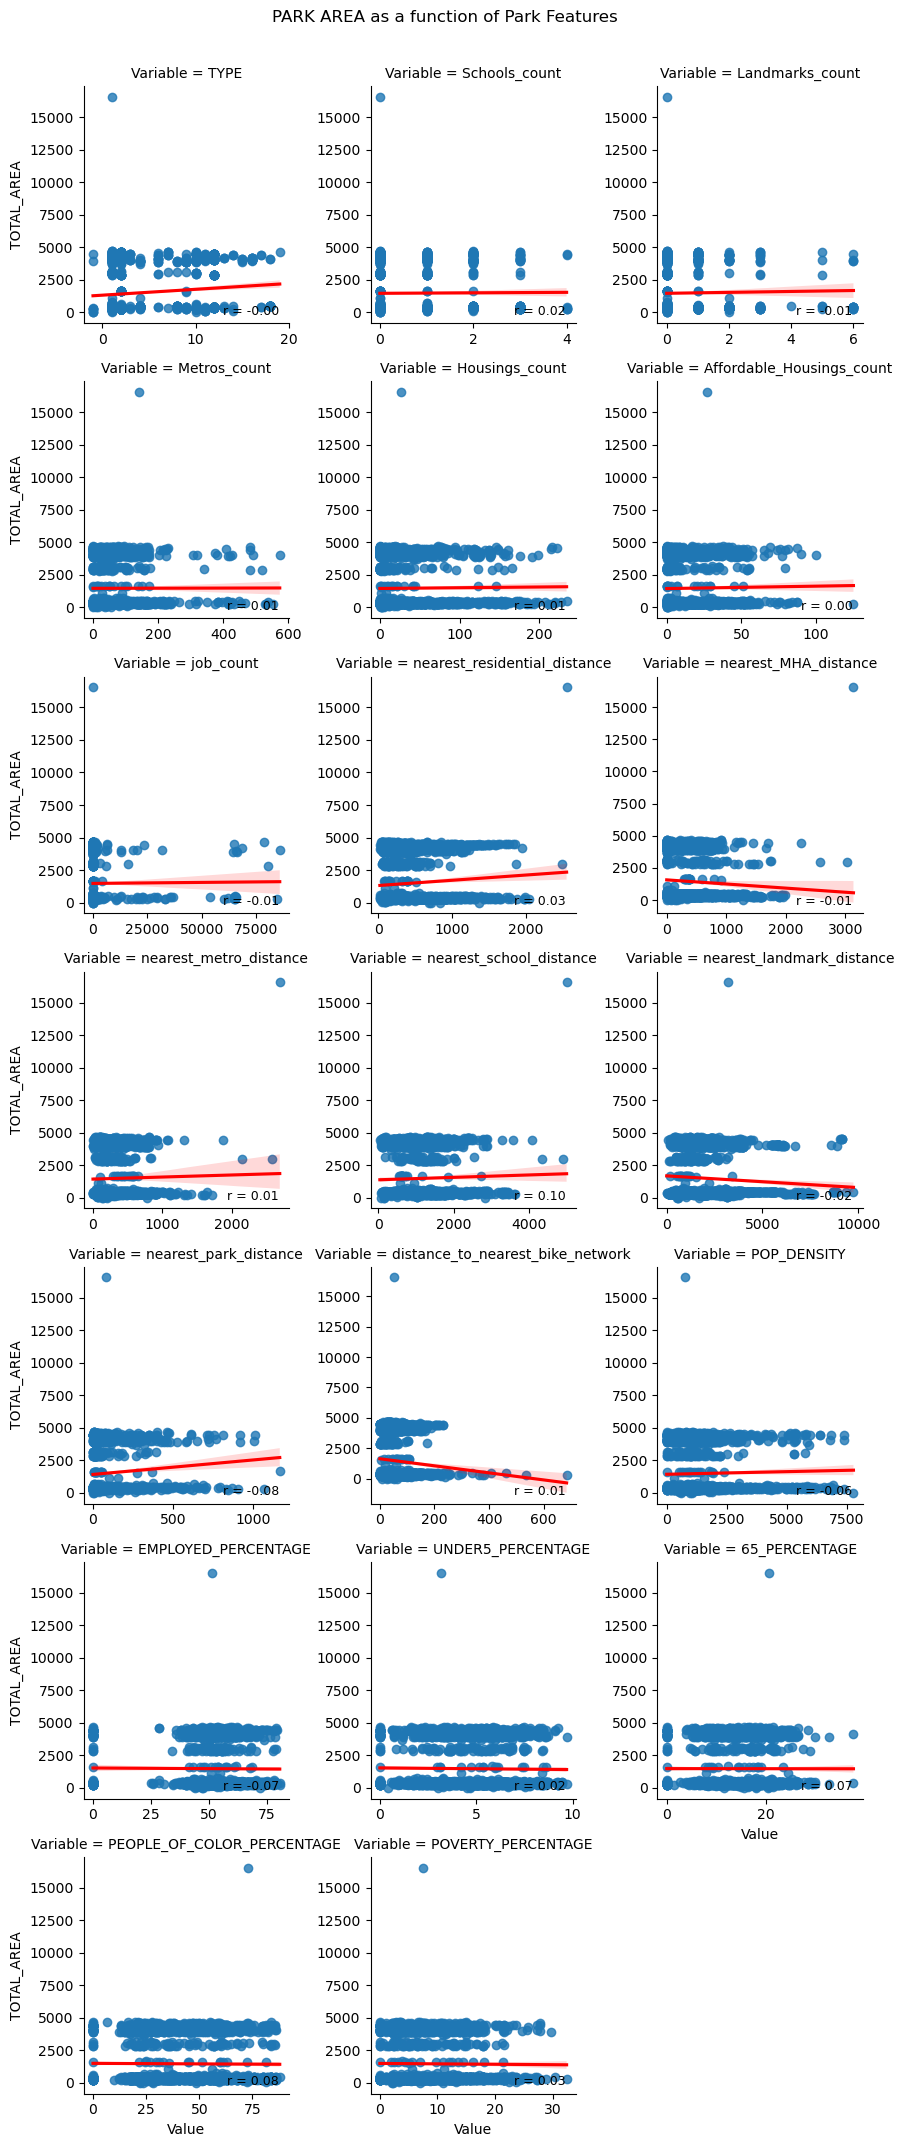

In [21]:
# Select variables for correlation analysis

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 将 DataFrame 转换为长格式
correlation_long = correlation_data.melt(id_vars=['TOTAL_AREA'], var_name='Variable', value_name='Value')

# 检查是否存在非数值数据并进行转换
correlation_long['Value'] = pd.to_numeric(correlation_long['Value'], errors='coerce')

# 删除转换为 NaN 的行
correlation_long = correlation_long.dropna(subset=['Value'])

# 计算相关系数
correlation_cor = correlation_long.groupby('Variable').apply(calculate_correlation).reset_index()
correlation_cor.columns = ['Variable', 'correlation']

# 打印结果
print(correlation_cor)

# 绘制相关性图
g = sns.FacetGrid(correlation_long, col="Variable", col_wrap=3, sharex=False, sharey=False)
g.map_dataframe(sns.regplot, x='Value', y='TOTAL_AREA', line_kws={"color": "red"})
g.set_axis_labels("Value", "TOTAL_AREA")
g.fig.suptitle("PARK AREA as a function of Park Features", y=1.02)

# 注释相关系数
for ax, label in zip(g.axes.flat, correlation_cor['correlation']):
    ax.text(0.95, 0.05, f'r = {label:.2f}', transform=ax.transAxes, ha='right', va='center', size=9)

plt.show()
